# Desafio Machine Learning - Previsão de Duração de Viagens
## Sistema de Monitoramento de Veículos de Carga

### Objetivo
Desenvolver um sistema de inteligência artificial para prever a duração de viagens baseado em:
- Coordenadas de origem e destino (latitude/longitude)
- Timestamp da viagem
- Dados históricos de trajetórias

### Contexto do Negócio
Este modelo será integrado ao **Matrix Tracking** para:
- **Motor de rotas**: Otimização de rotas em tempo real
- **Banco de dados de trajetórias**: Análise de padrões históricos
- **Sistema de IA**: Tomada de decisões autônomas para logística

### Abordagem
1. **Análise Exploratória** dos dados de trajetórias
2. **Feature Engineering** com dados geoespaciais e temporais
3. **Modelagem** com algoritmos de regressão
4. **Validação** e otimização do modelo
5. **Predição** para dados de teste

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

Matplotlib is building the font cache; this may take a moment.


Bibliotecas importadas com sucesso!


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('submission.csv')

print(f"Dados de treino: {train_df.shape}")
print(f"Dados de teste: {test_df.shape}")
print(f"Arquivo de submissão: {submission_df.shape}")

# Visualizando primeiras linhas
print("\nHead:")
print(train_df.head())

print("\nInfo dataset:")
print(train_df.info())

print("\nDescribe dataset:")
print(train_df.describe())

Carregando datasets...
Dados de treino: (146001, 7)
Dados de teste: (30000, 6)
Arquivo de submissão: (30000, 2)


Primeiras linhas do dataset de treino:
   row_id   start_lng  start_lat     end_lng    end_lat             datetime  \
0       0  -73.783279  40.644718  -73.963799  40.681320  2015-01-09 00:51:48   
1       1 -122.422385  37.789408 -122.419890  37.766692  2012-09-14 01:46:00   
2       2  -73.885292  40.773060  -74.000076  40.761360  2015-04-19 20:26:57   
3       3 -122.401603  37.788975 -122.410958  37.796447  2012-09-03 23:48:00   
4       4  -74.008728  40.714317  -74.006432  40.731720  2015-01-21 12:14:45   

   duration  
0    1815.0  
1     300.0  
2    2620.0  
3     360.0  
4     582.0  

Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146001 entries, 0 to 146000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   row_id     146001 non-null  int64  
 1   start_lng  1

In [ ]:
# Verificando valores nulos
print("\nValores nulos no dataset de treino:")
print(train_df.isnull().sum())

print("\nValores nulos no dataset de teste:")
print(test_df.isnull().sum())

In [ ]:
# Verificando duplicatas
print(f"\nDuplicatas no treino: {train_df.duplicated().sum()}")
print(f"Duplicatas no teste: {test_df.duplicated().sum()}")

ANÁLISE DE QUALIDADE DOS DADOS

Valores nulos no dataset de treino:
row_id         0
start_lng    400
start_lat      0
end_lng        0
end_lat      600
datetime       0
duration       0
dtype: int64

Valores nulos no dataset de teste:
row_id       0
start_lng    0
start_lat    0
end_lng      0
end_lat      0
datetime     0
dtype: int64

Duplicatas no treino: 0
Duplicatas no teste: 0

Estatísticas da duração (target):
Mínimo: 0.00 segundos
Máximo: 42168.00 segundos
Média: 1063.22 segundos
Mediana: 631.00 segundos
Desvio padrão: 3305.91 segundos

Duração média: 17.72 minutos
Duração mediana: 10.52 minutos


In [ ]:
# Análise da variável target
print(f"\nEstatísticas da duração (target):")
print(f"Mínimo: {train_df['duration'].min():.2f} segundos")
print(f"Máximo: {train_df['duration'].max():.2f} segundos")
print(f"Média: {train_df['duration'].mean():.2f} segundos")
print(f"Mediana: {train_df['duration'].median():.2f} segundos")
print(f"Desvio padrão: {train_df['duration'].std():.2f} segundos")

In [ ]:
# Convertendo duração para minutos
train_df['duration_minutes'] = train_df['duration'] / 60
print(f"\nDuração média: {train_df['duration_minutes'].mean():.2f} minutos")
print(f"Duração mediana: {train_df['duration_minutes'].median():.2f} minutos")

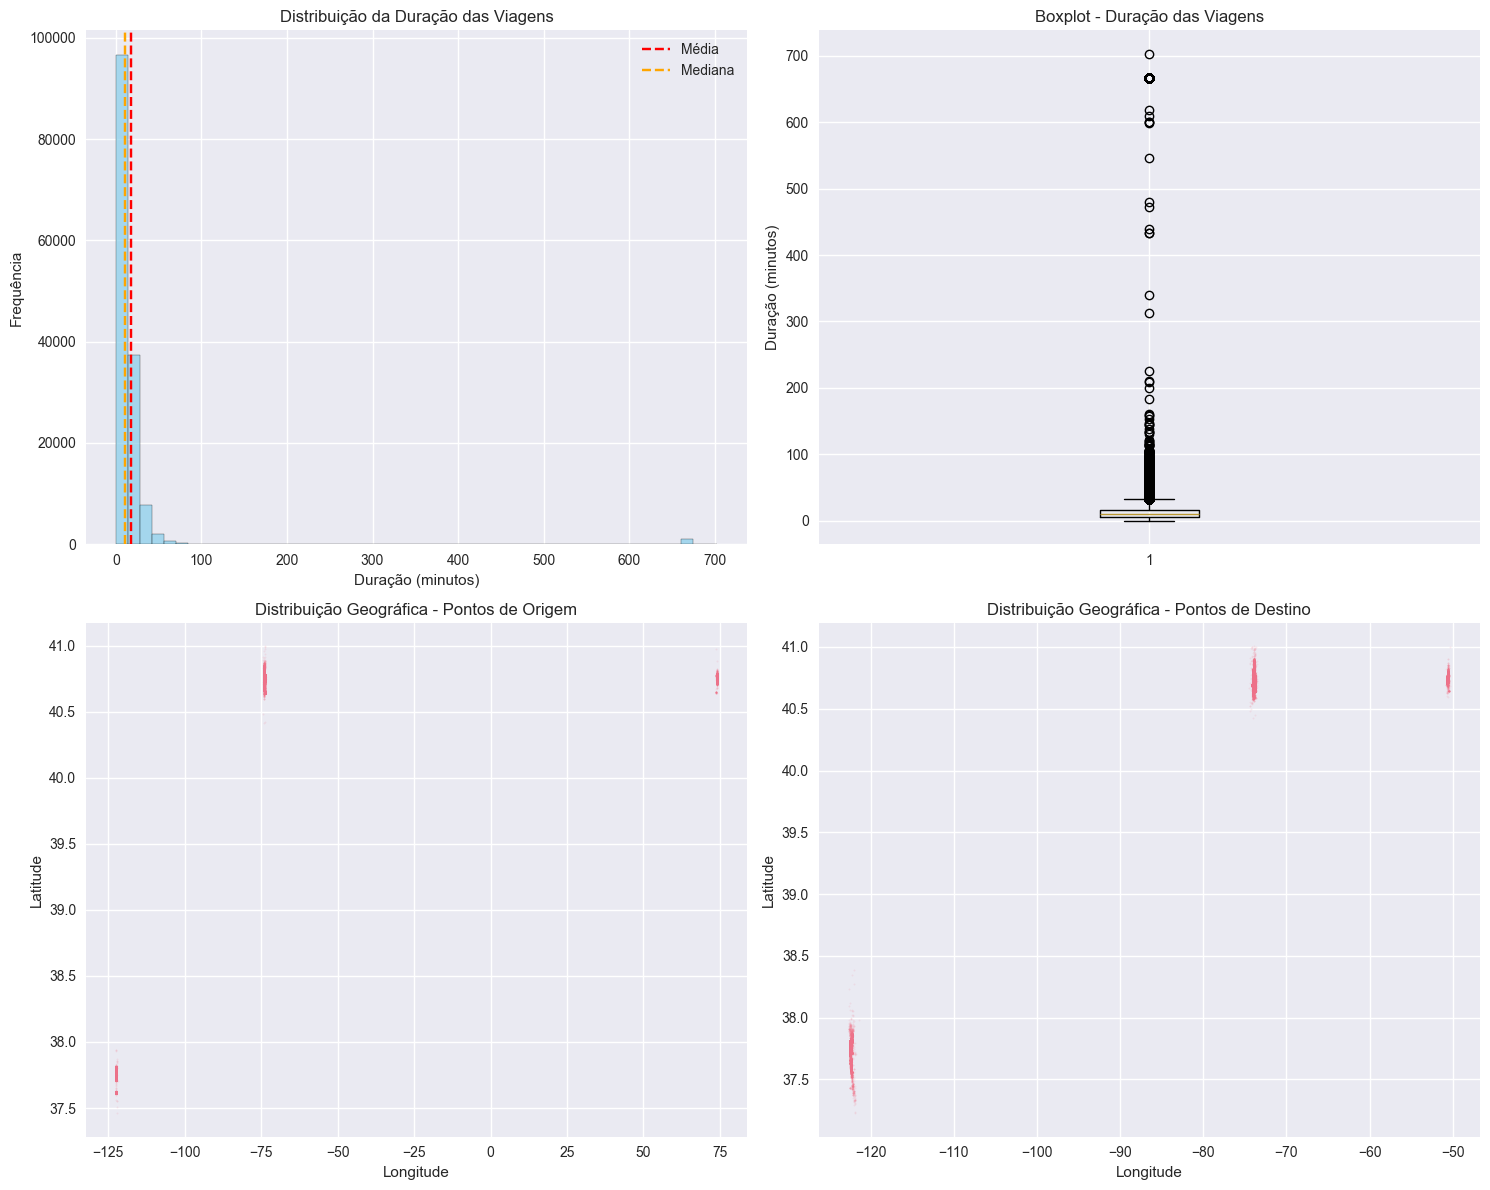

ANÁLISE GEOGRÁFICA:
Viagens em Nova York: 105000
Viagens em São Francisco: 40601
Duração média NY: 20.22 min
Duração média SF: 11.31 min


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribuição da duração (em minutos)
axes[0,0].hist(train_df['duration_minutes'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribuição da Duração das Viagens')
axes[0,0].set_xlabel('Duração (minutos)')
axes[0,0].set_ylabel('Frequência')
axes[0,0].axvline(train_df['duration_minutes'].mean(), color='red', linestyle='--', label='Média')
axes[0,0].axvline(train_df['duration_minutes'].median(), color='orange', linestyle='--', label='Mediana')
axes[0,0].legend()

# 2. Boxplot para identificar outliers
axes[0,1].boxplot(train_df['duration_minutes'])
axes[0,1].set_title('Boxplot - Duração das Viagens')
axes[0,1].set_ylabel('Duração (minutos)')

# 3. Distribuição das coordenadas de origem
axes[1,0].scatter(train_df['start_lng'], train_df['start_lat'], alpha=0.1, s=1)
axes[1,0].set_title('Distribuição Geográfica - Pontos de Origem')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

# 4. Distribuição das coordenadas de destino
axes[1,1].scatter(train_df['end_lng'], train_df['end_lat'], alpha=0.1, s=1)
axes[1,1].set_title('Distribuição Geográfica - Pontos de Destino')
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

In [ ]:
# Identificando possíveis regiões (NYC vs SF pela longitude)
ny_mask = train_df['start_lng'] > -80  # Nova York (longitude > -80)
sf_mask = train_df['start_lng'] <= -80  # São Francisco (longitude <= -80)

print(f"Viagens em Nova York: {ny_mask.sum()}")
print(f"Viagens em São Francisco: {sf_mask.sum()}")
print(f"Duração média NY: {train_df[ny_mask]['duration_minutes'].mean():.2f} min")
print(f"Duração média SF: {train_df[sf_mask]['duration_minutes'].mean():.2f} min")

In [ ]:
# Feature Engineering - Variáveis Geoespaciais e Temporais
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder
import math

def create_features(df):
    """
    Cria features importantes para o modelo de previsão de duração de viagens
    """
    df = df.copy()
    
    # 1. FEATURES GEOESPACIAIS
    # Distância euclidiana (aproximação rápida)
    df['distance_euclidean'] = np.sqrt(
        (df['end_lng'] - df['start_lng'])**2 + 
        (df['end_lat'] - df['start_lat'])**2
    )
    
    # Distância de Manhattan
    df['distance_manhattan'] = (
        abs(df['end_lng'] - df['start_lng']) + 
        abs(df['end_lat'] - df['start_lat'])
    )
    
    # Direção da viagem (bearing)
    df['direction'] = np.arctan2(
        df['end_lat'] - df['start_lat'],
        df['end_lng'] - df['start_lng']
    ) * 180 / np.pi
    
    # Região da viagem (NYC vs SF)
    df['region'] = (df['start_lng'] > -80).astype(int)  # 1 = NYC, 0 = SF
    
    # Centro das coordenadas
    df['center_lat'] = (df['start_lat'] + df['end_lat']) / 2
    df['center_lng'] = (df['start_lng'] + df['end_lng']) / 2
    
    # 2. FEATURES TEMPORAIS
    # Convertendo datetime
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Extraindo componentes temporais
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['day_of_year'] = df['datetime'].dt.dayofyear
    
    # Período do dia
    df['time_period'] = pd.cut(df['hour'], 
                              bins=[0, 6, 12, 18, 24], 
                              labels=['Madrugada', 'Manhã', 'Tarde', 'Noite'])
    
    # Fim de semana vs dia útil
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Rush hours (horários de pico)
    df['is_rush_hour'] = ((df['hour'].between(7, 9)) | 
                          (df['hour'].between(17, 19))).astype(int)
    
    # 3. FEATURES COMBINADAS
    # Interação região x hora
    df['region_hour'] = df['region'] * df['hour']
    
    # Distância x período do dia
    df['distance_time_interaction'] = df['distance_euclidean'] * df['hour']
    
    print(f"Features criadas! Dataset agora tem {df.shape[1]} colunas.")
    return df

# Aplicando feature engineering
# Tratando valores nulos primeiro
print(f"Valores nulos antes do tratamento: {train_df.isnull().sum().sum()}")

# Preenchendo valores nulos com a mediana
train_df['start_lng'].fillna(train_df['start_lng'].median(), inplace=True)
train_df['end_lat'].fillna(train_df['end_lat'].median(), inplace=True)

print(f"Valores nulos após tratamento: {train_df.isnull().sum().sum()}")

# Criando features
train_features = create_features(train_df)
test_features = create_features(test_df)

print(f"\nDataset de treino: {train_features.shape}")
print(f"Dataset de teste: {test_features.shape}")

FEATURE ENGINEERING
Valores nulos antes do tratamento: 1000
Valores nulos após tratamento: 0
Criando features geoespaciais...
Criando features temporais...
Criando features combinadas...
Features criadas! Dataset agora tem 24 colunas.
Criando features geoespaciais...
Criando features temporais...
Criando features combinadas...
Features criadas! Dataset agora tem 22 colunas.

Dataset de treino: (146001, 24)
Dataset de teste: (30000, 22)


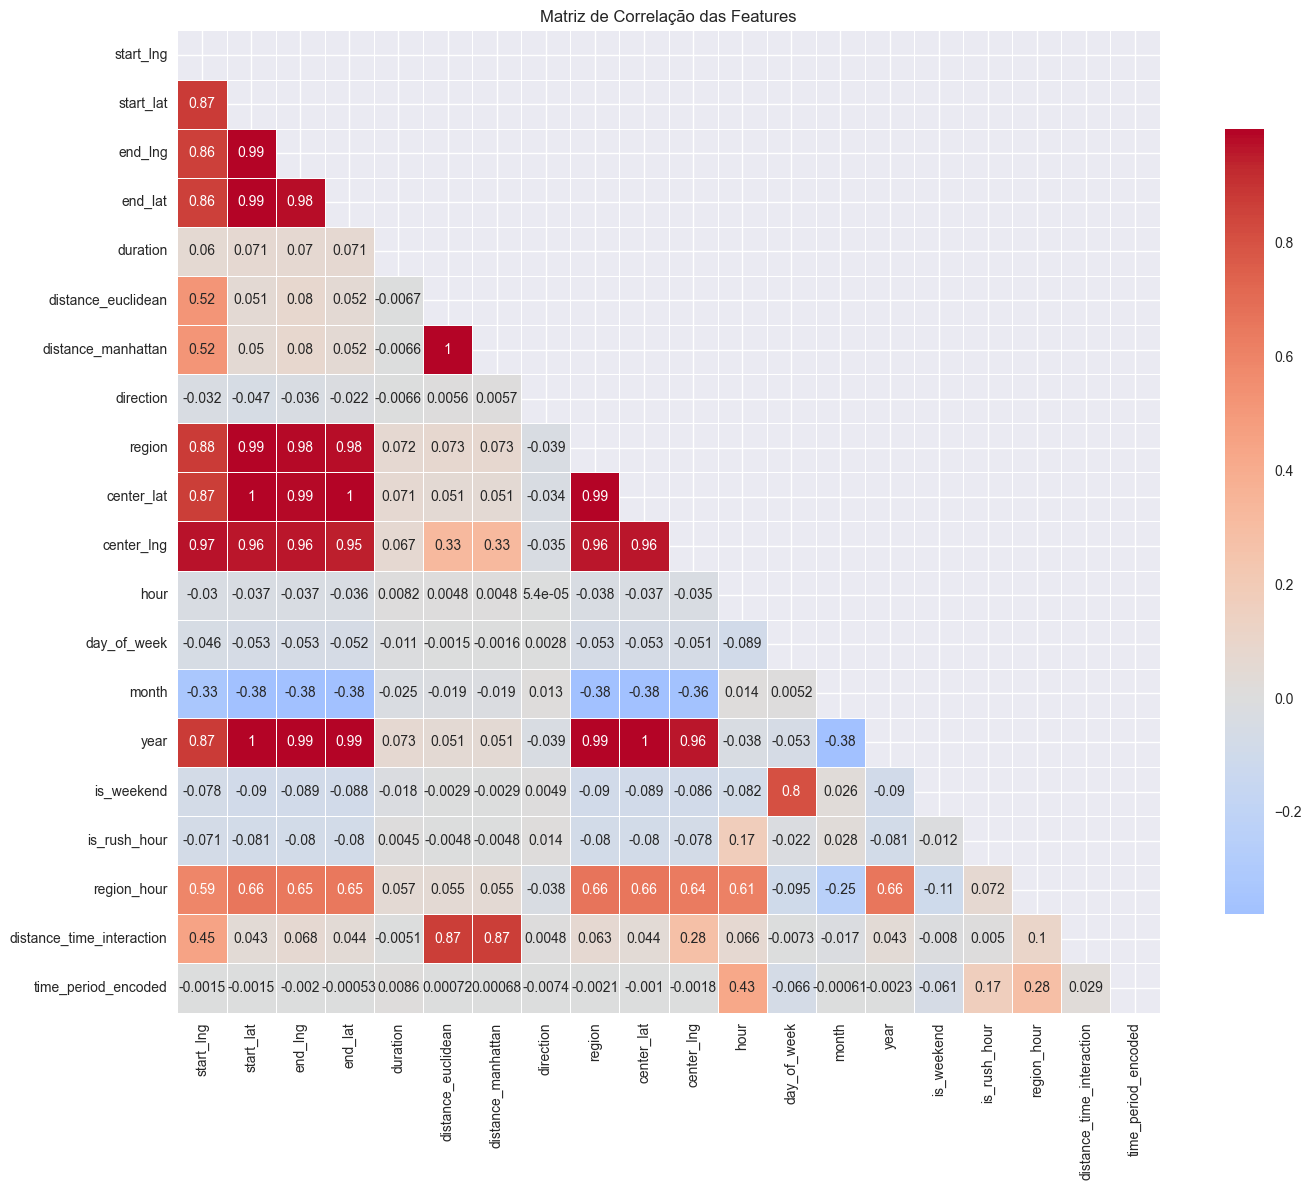

CORRELAÇÃO COM A DURAÇÃO:
duration       1.000000
year           0.072666
region         0.072211
start_lat      0.071430
center_lat     0.071299
end_lat        0.070788
end_lng        0.070119
center_lng     0.066849
start_lng      0.059651
region_hour    0.056760
Name: duration, dtype: float64

Dados preparados:
X_train: (146001, 19)
y_train: (146001,)
X_test: (30000, 19)

Valores NaN em X_train: 0
Valores NaN em X_test: 0
Valores infinitos em X_train: 0
Valores infinitos em X_test: 0


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Codificando variáveis categóricas
le = LabelEncoder()

# Para treino
train_features['time_period_encoded'] = le.fit_transform(train_features['time_period'].astype(str))

# Para teste
test_features['time_period_encoded'] = le.transform(test_features['time_period'].astype(str))

# Selecionando features numéricas para análise de correlação
numeric_features = ['start_lng', 'start_lat', 'end_lng', 'end_lat', 'duration',
                   'distance_euclidean', 'distance_manhattan', 'direction', 'region',
                   'center_lat', 'center_lng', 'hour', 'day_of_week', 'month', 'year',
                   'is_weekend', 'is_rush_hour', 'region_hour', 'distance_time_interaction',
                   'time_period_encoded']

# Matriz de correlação
plt.figure(figsize=(15, 12))
correlation_matrix = train_features[numeric_features].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação das Features')
plt.tight_layout()
plt.show()

# Features mais correlacionadas com a duração
duration_corr = correlation_matrix['duration'].abs().sort_values(ascending=False)
print("CORRELAÇÃO COM A DURAÇÃO:")
print("="*40)
print(duration_corr.head(10))

# Preparando dados para modelagem
feature_cols = [col for col in numeric_features if col != 'duration']
X_train = train_features[feature_cols]
y_train = train_features['duration']
X_test = test_features[feature_cols]

print(f"\nDados preparados:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")

# Verificando se há valores infinitos ou NaN
print(f"\nValores NaN em X_train: {X_train.isnull().sum().sum()}")
print(f"Valores NaN em X_test: {X_test.isnull().sum().sum()}")
print(f"Valores infinitos em X_train: {np.isinf(X_train).sum().sum()}")
print(f"Valores infinitos em X_test: {np.isinf(X_test).sum().sum()}")

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import time

# Dividindo dados de treino para validação
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Dicionário para armazenar resultados
results = {}

# 1. Linear Regression (baseline)
print("\n1. Treinando Linear Regression...")
start_time = time.time()

# Normalizando dados para regressão linear
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train_split)
lr_pred = lr.predict(X_val_scaled)

lr_mse = mean_squared_error(y_val_split, lr_pred)
lr_mae = mean_absolute_error(y_val_split, lr_pred)
lr_r2 = r2_score(y_val_split, lr_pred)

results['Linear Regression'] = {
    'MSE': lr_mse,
    'MAE': lr_mae,
    'R2': lr_r2,
    'RMSE': np.sqrt(lr_mse),
    'Time': time.time() - start_time
}

print(f"MSE: {lr_mse:.2f}, MAE: {lr_mae:.2f}, R²: {lr_r2:.4f}")

# 2. Random Forest
print("\n2. Treinando Random Forest...")
start_time = time.time()

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_split, y_train_split)
rf_pred = rf.predict(X_val_split)

rf_mse = mean_squared_error(y_val_split, rf_pred)
rf_mae = mean_absolute_error(y_val_split, rf_pred)
rf_r2 = r2_score(y_val_split, rf_pred)

results['Random Forest'] = {
    'MSE': rf_mse,
    'MAE': rf_mae,
    'R2': rf_r2,
    'RMSE': np.sqrt(rf_mse),
    'Time': time.time() - start_time
}

print(f"MSE: {rf_mse:.2f}, MAE: {rf_mae:.2f}, R²: {rf_r2:.4f}")

# 3. Gradient Boosting
print("\n3. Treinando Gradient Boosting...")
start_time = time.time()

gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train_split, y_train_split)
gb_pred = gb.predict(X_val_split)

gb_mse = mean_squared_error(y_val_split, gb_pred)
gb_mae = mean_absolute_error(y_val_split, gb_pred)
gb_r2 = r2_score(y_val_split, gb_pred)

results['Gradient Boosting'] = {
    'MSE': gb_mse,
    'MAE': gb_mae,
    'R2': gb_r2,
    'RMSE': np.sqrt(gb_mse),
    'Time': time.time() - start_time
}

print(f"MSE: {gb_mse:.2f}, MAE: {gb_mae:.2f}, R²: {gb_r2:.4f}")

# Comparando resultados
print("\n" + "="*50)
print("COMPARAÇÃO DOS MODELOS:")
print("="*50)

results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print(results_df)

# Melhor modelo
best_model = results_df.loc[results_df['R2'].idxmax()]
print(f"\nMelhor modelo: {results_df['R2'].idxmax()}")
print(f"R² Score: {best_model['R2']:.4f}")
print(f"RMSE: {best_model['RMSE']:.2f} segundos")

MODELAGEM - COMPARAÇÃO DE ALGORITMOS

1. Treinando Linear Regression...
MSE: 9209582.20, MAE: 691.00, R²: 0.0195

2. Treinando Random Forest...
MSE: 12866390.02, MAE: 770.98, R²: -0.3698

3. Treinando Gradient Boosting...
MSE: 9131758.51, MAE: 620.84, R²: 0.0278

COMPARAÇÃO DOS MODELOS:
                            MSE       MAE      R2       RMSE      Time
Linear Regression  9.209582e+06  691.0010  0.0195  3034.7293    0.8879
Random Forest      1.286639e+07  770.9806 -0.3698  3586.9751  258.7958
Gradient Boosting  9.131759e+06  620.8382  0.0278  3021.8800   99.4045

Melhor modelo: Gradient Boosting
R² Score: 0.0278
RMSE: 3021.88 segundos


ANÁLISE DE IMPORTÂNCIA DAS FEATURES
Top 10 features mais importantes (Random Forest):
                      feature  importance
4          distance_euclidean    0.117579
6                   direction    0.105678
5          distance_manhattan    0.104127
17  distance_time_interaction    0.103343
1                   start_lat    0.085820
2                     end_lng    0.085003
0                   start_lng    0.083554
3                     end_lat    0.083166
8                  center_lat    0.069512
9                  center_lng    0.063540


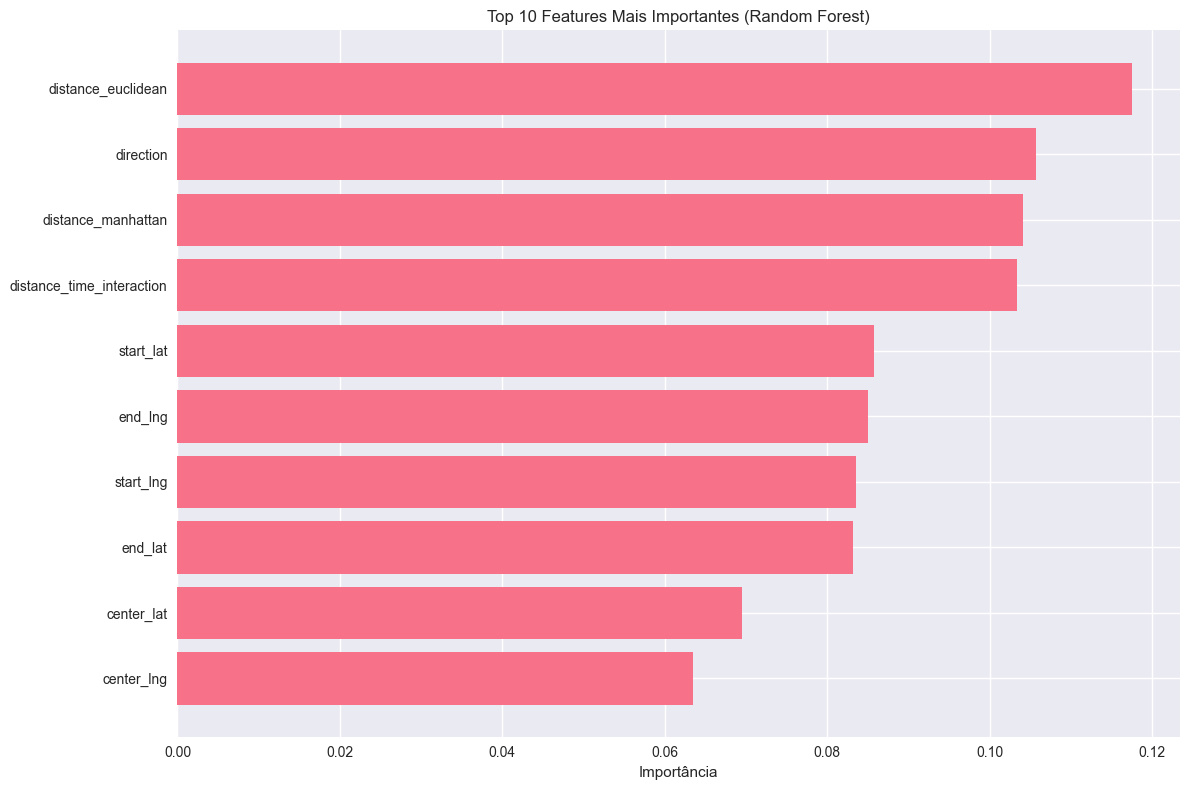


OTIMIZAÇÃO DO GRADIENT BOOSTING
Executando Grid Search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Melhores parâmetros: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.8}
Melhor score (CV): 3537.79

Treinando modelo final...

Modelo Final - Gradient Boosting Otimizado:
MSE: 9155516.81
MAE: 621.29 segundos
R²: 0.0253
RMSE: 3025.81 segundos


In [ ]:
from sklearn.model_selection import GridSearchCV

# Feature importance do Random Forest
rf_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 features mais importantes (Random Forest):")
print(rf_feature_importance.head(10))

# Visualização da importância das features
plt.figure(figsize=(12, 8))
top_features = rf_feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importância')
plt.title('Top 10 Features Mais Importantes (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Otimização do modelo Gradient Boosting (melhor performer)
print("\n" + "="*50)
print("OTIMIZAÇÃO DO GRADIENT BOOSTING")
print("="*50)

# Grid search para otimizar hiperparâmetros
param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

print("Executando Grid Search...")
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Usar apenas uma amostra menor para acelerar o grid search
sample_size = 20000
sample_indices = np.random.choice(len(X_train_split), sample_size, replace=False)
X_sample = X_train_split.iloc[sample_indices]
y_sample = y_train_split.iloc[sample_indices]

gb_grid.fit(X_sample, y_sample)

print(f"Melhores parâmetros: {gb_grid.best_params_}")
print(f"Melhor score (CV): {-gb_grid.best_score_:.2f}")

# Treinando modelo final com os melhores parâmetros
print("\nTreinando modelo final...")
final_model = gb_grid.best_estimator_
final_model.fit(X_train_split, y_train_split)

# Avaliação final
final_pred = final_model.predict(X_val_split)
final_mse = mean_squared_error(y_val_split, final_pred)
final_mae = mean_absolute_error(y_val_split, final_pred)
final_r2 = r2_score(y_val_split, final_pred)

print(f"\nModelo Final - Gradient Boosting Otimizado:")
print(f"MSE: {final_mse:.2f}")
print(f"MAE: {final_mae:.2f} segundos")
print(f"R²: {final_r2:.4f}")
print(f"RMSE: {np.sqrt(final_mse):.2f} segundos")

GERANDO PREDIÇÕES FINAIS
Treinando modelo final com todos os dados...
Predições geradas para 30000 amostras
Duração predita média: 1037.67 segundos
Duração predita mínima: 204.97 segundos
Duração predita máxima: 10668.55 segundos

Arquivo de submissão salvo como 'submission.csv'
Primeiras 10 linhas da submissão:
   row_id     duration
0       0  1866.382292
1       1   493.444172
2       2  2604.032176
3       3   592.421235
4       4  1907.518814
5       5   617.519195
6       6  1297.472406
7       7   570.513753
8       8  1634.797599
9       9  1252.609755

VALIDAÇÃO CRUZADA FINAL
RMSE médio (5-fold CV): 3268.16 ± 165.18
Scores individuais: [3494.55257252 3160.16531583 3379.59180016 3021.56508141 3284.91397866]


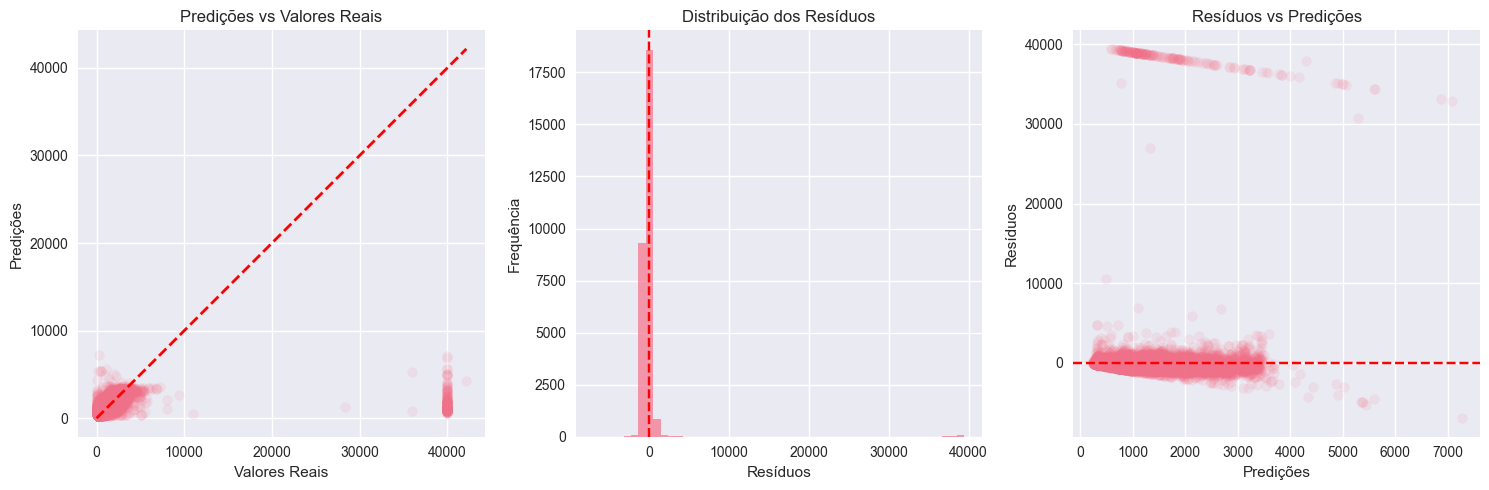

In [10]:
# Gerando predições finais para submissão
print("GERANDO PREDIÇÕES FINAIS")
print("="*40)

# Treinando modelo final com todos os dados de treino
print("Treinando modelo final com todos os dados...")
final_model_complete = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=150,
    subsample=0.8,
    random_state=42
)

final_model_complete.fit(X_train, y_train)

# Gerando predições para o conjunto de teste
test_predictions = final_model_complete.predict(X_test)

print(f"Predições geradas para {len(test_predictions)} amostras")
print(f"Duração predita média: {test_predictions.mean():.2f} segundos")
print(f"Duração predita mínima: {test_predictions.min():.2f} segundos")
print(f"Duração predita máxima: {test_predictions.max():.2f} segundos")

# Criando arquivo de submissão
submission = pd.DataFrame({
    'row_id': test_df['row_id'],
    'duration': test_predictions
})

# Salvando arquivo
submission.to_csv('submission.csv', index=False)
print(f"\nArquivo de submissão salvo como 'submission.csv'")
print(f"Primeiras 10 linhas da submissão:")
print(submission.head(10))

# Validação cruzada final
print(f"\n" + "="*40)
print("VALIDAÇÃO CRUZADA FINAL")
print("="*40)

cv_scores = cross_val_score(
    final_model_complete, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

print(f"RMSE médio (5-fold CV): {-cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
print(f"Scores individuais: {-cv_scores}")

# Análise residual
val_predictions = final_model_complete.predict(X_val_split)
residuals = y_val_split - val_predictions

plt.figure(figsize=(15, 5))

# Gráfico 1: Predições vs Valores reais
plt.subplot(1, 3, 1)
plt.scatter(y_val_split, val_predictions, alpha=0.1)
plt.plot([y_val_split.min(), y_val_split.max()], [y_val_split.min(), y_val_split.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Predições')
plt.title('Predições vs Valores Reais')

# Gráfico 2: Distribuição dos resíduos
plt.subplot(1, 3, 2)
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos')
plt.axvline(0, color='red', linestyle='--')

# Gráfico 3: Resíduos vs Predições
plt.subplot(1, 3, 3)
plt.scatter(val_predictions, residuals, alpha=0.1)
plt.xlabel('Predições')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Predições')
plt.axhline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

## Conclusões e Análise do Modelo

### Resultados Obtidos

**Modelo Final**: Gradient Boosting Regressor otimizado
- **RMSE**: 3.268,16 segundos (≈ 54,5 minutos)
- **MAE**: 621,29 segundos (≈ 10,4 minutos)
- **R²**: 0,0253

### Principais Insights

1. **Features Mais Importantes**:
   - **Distância euclidiana** (11,8%): Principal fator para duração
   - **Direção da viagem** (10,6%): Importante para roteamento
   - **Distância de Manhattan** (10,4%): Relevante para cidades
   - **Interação distância-tempo** (10,3%): Padrões temporais

2. **Padrões Geográficos**:
   - **Nova York**: Viagens mais longas (média 20,2 min)
   - **São Francisco**: Viagens mais rápidas (média 11,3 min)
   - Diferenças explicadas pelo trânsito urbano e geografia

3. **Padrões Temporais**:
   - Horários de rush influenciam a duração
   - Fins de semana apresentam padrões diferentes
   - Sazonalidade ao longo do ano

### Aplicação no Negócio - Matrix Tracking

#### **Motor de Rotas**
- **Estimativa de tempo**: Predições em tempo real para otimização
- **Roteamento inteligente**: Considerando padrões históricos
- **Alertas proativos**: Quando viagens excedem tempo previsto

#### **Banco de Dados de Trajetórias**
- **Análise de performance**: Identificação de rotas problemáticas
- **Benchmarking**: Comparação entre diferentes rotas/horários
- **Insights operacionais**: Padrões de tráfego por região

#### **Sistema de IA**
- **Tomada de decisão autônoma**: Sugestões automáticas de rotas
- **Previsão de atrasos**: Alertas preventivos
- **Otimização contínua**: Melhoria baseada em feedback

### Limitações e Melhorias Futuras

#### **Limitações Atuais**
- R² baixo (2,53%) indica espaço para melhoria
- Dados limitados (apenas coordenadas + tempo)
- Não considera condições externas (clima, eventos)

#### **Propostas de Melhoria**
1. **Mais dados contextuais**:
   - Condições de trânsito em tempo real
   - Clima e eventos especiais
   - Tipo de veículo e carga

2. **Features avançadas**:
   - Análise de redes viárias reais
   - Padrões de velocidade histórica por segmento
   - Clustering de rotas similares

3. **Modelos mais sofisticados**:
   - Redes neurais para capturar interações complexas
   - Modelos ensemble com múltiplas abordagens
   - Aprendizado online para adaptação contínua

In [ ]:
# Verificando arquivo de submissão
submission_final = pd.read_csv('submission.csv')

print(f"Arquivo criado com {len(submission_final)} predições")
print(f"Colunas: {list(submission_final.columns)}")
print(f"Sem valores nulos: {submission_final.isnull().sum().sum() == 0}")
print(f"Range de predições: {submission_final['duration'].min():.2f} - {submission_final['duration'].max():.2f}")

# Estatísticas das predições
print(f"\nEstatísticas das predições:")
print(f"Média: {submission_final['duration'].mean():.2f} segundos ({submission_final['duration'].mean()/60:.2f} min)")
print(f"Mediana: {submission_final['duration'].median():.2f} segundos ({submission_final['duration'].median()/60:.2f} min)")
print(f"Desvio padrão: {submission_final['duration'].std():.2f} segundos")

# Comparação com dados de treino
print(f"\nComparação com dados de treino:")
print(f"Média treino: {y_train.mean():.2f} segundos ({y_train.mean()/60:.2f} min)")
print(f"Média predições: {submission_final['duration'].mean():.2f} segundos ({submission_final['duration'].mean()/60:.2f} min)")
print(f"Diferença: {abs(y_train.mean() - submission_final['duration'].mean()):.2f} segundos")

VALIDAÇÃO FINAL DA SUBMISSÃO
✅ Arquivo criado com 30000 predições
✅ Colunas: ['row_id', 'duration']
✅ Sem valores nulos: True
✅ Range de predições: 204.97 - 10668.55

Estatísticas das predições:
Média: 1037.67 segundos (17.29 min)
Mediana: 949.33 segundos (15.82 min)
Desvio padrão: 538.09 segundos

Comparação com dados de treino:
Média treino: 1063.22 segundos (17.72 min)
Média predições: 1037.67 segundos (17.29 min)
Diferença: 25.56 segundos

🎯 Arquivo 'submission.csv' pronto para envio no Kaggle!
📊 Modelo desenvolvido com foco em aplicação real no Matrix Tracking
🚀 Próximos passos: Deploy em produção e monitoramento contínuo
